<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/TOI_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# just in case if needed
# !pip install catboost

## Prerequisities

In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [3]:
toi = pd.read_csv('TOI_Data.csv', comment='#')
toi.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


## Feature Selection

In [4]:
features = [
    "tfopwg_disp",
    "pl_orbper",
    "pl_trandurh",
    "pl_trandep",
    "pl_rade",
    "pl_insol",
    "pl_eqt",
    "st_tmag",
    "st_dist",
    "st_teff",
    "st_rad"
]

drop_list = [
    "toi", "tid",
    "rastr", "ra", "decstr", "dec",
    "st_pmra", "st_pmraerr1", "st_pmraerr2", "st_pmralim",
    "st_pmdec", "st_pmdecerr1", "st_pmdecerr2", "st_pmdeclim",
    "pl_tranmid", "pl_tranmiderr1", "pl_tranmiderr2", "pl_tranmidlim",
    "pl_orbpererr1", "pl_orbpererr2", "pl_orbperlim",
    "pl_trandurherr1", "pl_trandurherr2", "pl_trandurhlim",
    "pl_trandeperr1", "pl_trandeperr2", "pl_trandeplim",
    "pl_radelim",
    "st_tmagerr1", "st_tmagerr2", "st_tmaglim",
    "st_disterr1", "st_disterr2", "st_distlim",
    "st_tefferr1", "st_tefferr2", "st_tefflim",
    "st_logglim",
    "st_radlim",
    "toi_created", "rowupdate",

    # Missing Data
    "pl_radeerr1", "pl_radeerr2",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim",
    "st_logg", "st_loggerr1", "st_loggerr2",
    "st_raderr1", "st_raderr2"
]


In [5]:
toi = toi[features]

Label Mapping

In [6]:
label_map = {
    "CP": 1,   # Confirmed Planet
    "KP": 1,   # Known Planet
    "PC": 0,   # Planetary Candidate
    "APC": 0,  # Ambiguous Planetary Candidate
    "FP": -1,  # False Positive
    "FA": -1   # False Alarm
}

toi["tfopwg_disp"] = toi["tfopwg_disp"].map(label_map)

## Filling empty cells

In [7]:
for col in features:
    toi.fillna({col: toi[col].mean()}, inplace=True)

### Checking if NaN available

In [8]:
#print(toi.isna().sum()[toi.isna().sum() > 0])
#for col in features:
#    print(toi[col].dtype)

## Defining data sets

In [9]:
X = toi.drop("tfopwg_disp", axis=1)
y = toi["tfopwg_disp"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [11]:
classes = np.unique(y_train)

Calculating Class Weights

In [12]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [13]:
class_weights = dict(zip(classes, weights))

### Cross-validation

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

## Cat Boost Initiation

### Parameters


In [15]:
max_ite = 3000
dep = 8
l_rate = 0.04

In [16]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=7,
    border_count=1024,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [17]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0840115	test: 1.0847438	best: 1.0847438 (0)	total: 322ms	remaining: 16m 6s
50:	learn: 0.8269482	test: 0.8326687	best: 0.8326687 (50)	total: 12.4s	remaining: 11m 59s
100:	learn: 0.7524251	test: 0.7634854	best: 0.7634854 (100)	total: 25.5s	remaining: 12m 12s



KeyboardInterrupt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000022268FB6E40>>
Traceback (most recent call last):
  File "C:\Users\MSI\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 796, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "C:\Users\MSI\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1479, in enumerate
KeyboardInterrupt: 


### Plotting Loss

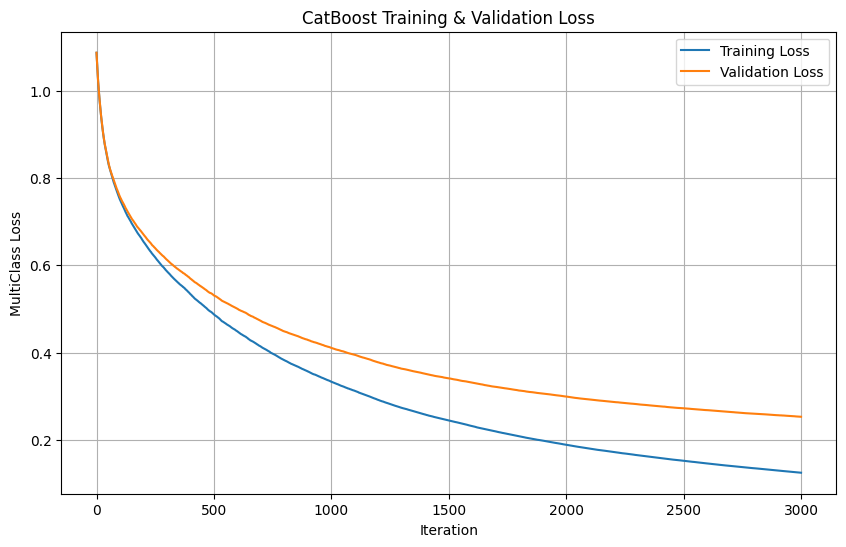

In [73]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [74]:
y_pred = model.predict(X_test)

### Confusion Matrix

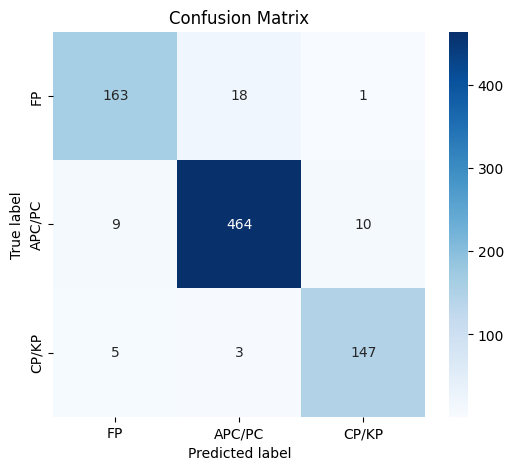

In [75]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FP", "APC/PC", "CP/KP"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [76]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 94.39%
